# ỨNG DỤNG CLUSTERING ĐỂ PHÁT HIỆN ẢNH TRÙNG

1. Yêu cầu chung: Dùng kỹ thuật clustering để tạo công cụ hỗ trợ phát hiện các ảnh trùng nhau

2. Yêu cầu cụ thể:
  - Input: Danh sách các ảnh được lưu trong tập tin, ví dụ CarDataset-Splits-1-Train.csv (xem mô tả https://colab.research.google.com/drive/1gf0GzvW0tHddKtuvMUNIvglUT-J6oW6S?usp=sharing)
  - Output: Danh sách các clusters và hiển thị các ảnh trong cluster

3. Hướng dẫn:
  - Bước 1:
    - Mỗi ảnh cần thực hiện bước rút trích đặc trưng (feature extraction), biểu diễn dưới dạng một vector đặc trưng d chiều (d-dimension).
    - Có nhiều công cụ hỗ trợ bước rút trích đặc trưng, trong bài tập này, chúng ta sẽ chọn một công cụ sao cho tốc độ xử lý nhanh nhưng kết quả tốt. Các mô hình MobileNet (https://keras.io/api/applications/mobilenet/) có thể được dùng vì đáp ứng các tiêu chí này.
  - Bước 2:
    - Chọn một thuật toán clustering - ví dụ K-Means (số lượgn clusters K=5)
    - Ghi kết quả clustering ra tập tin - thay CategoryID bằng ClusterID
  - Bước 3:
    - Hiển thị kết quả clustering - kế thừa kết quả của bài tập Hiển thị dữ liệu https://colab.research.google.com/drive/1rHbKlJd7O9E49SsJlHnZNKcyTbwXT_Ls?usp=sharing
    - Từ kết quả hiển thị, nếu các ảnh nhìn trùng nhau, nhưng tên tập tin khác nhau thì có thể đưa vào danh sách hậu kiểm.

## **Thông tin của tác giả, ngày cập nhật**
<hr>

**Thành viên nhóm**:
- **Trần Đình Khánh Đăng - 22520195**
- **Tăng Nhất - 22521027**
- **Lê Minh Nhựt - 22521060**

**Ngày cập nhật**: 13/12/2024

## **Code**

### **Import thư viện cần thiết**

In [13]:
import cv2
import os
import torch
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras.applications import (
    MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
    ResNet50, ResNet101, ResNet152,
    VGG16, VGG19,
    EfficientNetB0, EfficientNetB1, EfficientNetB7,
    InceptionV3, Xception
)

from PIL import Image
from tqdm import tqdm
from skimage.io import imread
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications.mobilenet import preprocess_input


### **Mount Drive Colab**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = './drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Public'
dataset_dir = './drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset'

categories = ['Others', 'Honda', 'Hyundai', 'KIA', 'Mazda', 'Mitsubishi', 'Suzuki', 'Toyota', 'VinFast']

def get_indexing(categories):
    indexing = {category: idx for idx, category in enumerate(categories)}
    invert_indexing = {idx: category for category, idx in indexing.items()}
    return indexing, invert_indexing

indexing, invert_indexing = get_indexing(categories)

### **Bước 1**: Feature Extraction

In [4]:
def extract_feature_one_img(image_path, model, input_shape=(224, 224)):
    img = image.load_img(image_path, target_size=input_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

def extract_features(df=None,
                     base_dir='./',
                     dataset_dir='./',
                     file_csv='CarDataset-Splits-1-Train.csv',
                     model_name='MobileNet',
                     input_shape=(224, 224),
                     partition=False,
                     partition_size=1000,
                     random_state=42,
                     save_result=False,
                     save_name='extracted_features-Splits-1.npz'):
    models = {
        'MobileNet': MobileNet,
        'MobileNetV2': MobileNetV2,
        'MobileNetV3Small': MobileNetV3Small,
        'MobileNetV3Large': MobileNetV3Large,
        'ResNet50': ResNet50,
        'ResNet101': ResNet101,
        'ResNet152': ResNet152,
        'VGG16': VGG16,
        'VGG19': VGG19,
        'EfficientNetB0': EfficientNetB0,
        'EfficientNetB1': EfficientNetB1,
        'EfficientNetB7': EfficientNetB7,
        'InceptionV3': InceptionV3,
        'Xception': Xception
    }

    if model_name not in models:
        model_name = 'MobileNet'

    device = '/device:GPU:0' if tf.config.list_physical_devices('GPU') else '/device:CPU:0'
    print(f"Using device: {device}")

    with tf.device(device):
        model = models[model_name](weights='imagenet', include_top=False, pooling='avg')

    if df is None:
        df = pd.read_csv(os.path.join(dataset_dir, file_csv))

    if partition:
        sampled_df = df.sample(n=min(partition_size, len(df)), random_state=random_state).reset_index(drop=True)
        print(f"Processing {len(sampled_df)} images out of {len(df)} available.")
    else:
        sampled_df = df
    print("Extracting features...")

    result = []
    for image_path in tqdm(sampled_df["ImageFullPath"].values, desc="Extracting Features"):
        full_path = os.path.join(base_dir, image_path)
        try:
            extracted_features = extract_feature_one_img(full_path, model, input_shape=input_shape)
            result.append({'ImagePath': image_path, 'Extracted Features': extracted_features})
        except Exception as e:
            print(f"Error processing image {full_path}: {e}. Skipping...")

    print(f"Successfully processed {len(result)} images")

    if save_result:
        save_path = os.path.join(dataset_dir, save_name)
        np.savez(save_path, extracted_features=result)
        print(f"Extracted features saved to {save_path}")

    return result


In [5]:
extracted_features = extract_features(base_dir=base_dir,
                                      dataset_dir=dataset_dir,
                                      file_csv='CarDataset-Splits-1-Train.csv',
                                      model_name='MobileNet',
                                      input_shape=(224, 224),
                                      partition=True,
                                      partition_size=1000,
                                      save_result=True,
                                      save_name='extracted_features-Splits-1.npz',
                                      )

Using device: /device:CPU:0


<ipython-input-4-9a208a85b6a2>:42: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = models[model_name](weights='imagenet', include_top=False, pooling='avg')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Processing 1000 images out of 26467 available.


Extracting Features:  48%|████▊     | 481/1000 [06:42<05:51,  1.48it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Extracting Features:  80%|████████  | 805/1000 [10:49<02:33,  1.27it/s]

Error processing image ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Public/Others/22521463-22521213-22521259.Others.53.jpg: cannot identify image file <_io.BytesIO object at 0x78ccef6e6de0>. Skipping...


Extracting Features: 100%|██████████| 1000/1000 [13:17<00:00,  1.25it/s]


Successfully processed 999 images
Extracted features saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/extracted_features-Splits-1.npz


### **Bước 2**: Clustering

In [6]:
def perform_clustering(extracted_features=None,
                       dataset_dir='./',
                       extracted_file='extracted_features-Splits-1.npz',
                       n_clusters=9,
                       random_state=0,
                       save_file=False,
                       save_name='Clustering_Results.csv',
                       ) -> pd.DataFrame:
    if extracted_features == None:
        data = np.load(os.path.join(dataset_dir, extracted_file), allow_pickle=True)
        extracted_features = data['extracted_features']

    features_list = [x['Extracted Features'] for x in extracted_features]
    image_path_list = [x['ImagePath'] for x in extracted_features]

    clustering = KMeans(n_clusters=n_clusters, random_state=random_state).fit(features_list)

    df = pd.DataFrame({'ImageFullPath': image_path_list, 'ClusterID': clustering.labels_})
    if save_file:
      save_path = os.path.join(dataset_dir, save_name)
      df.to_csv(save_path, index=False)
      print(f"Saved to {save_path}")

    return df, clustering, features_list, image_path_list

In [7]:
df, clustering, features_list, image_path_list = perform_clustering(dataset_dir=dataset_dir,
                                                                    extracted_file='extracted_features-Splits-1.npz',
                                                                    save_file=True,
                                                                    save_name='Clustering_results.csv',
                                                                    )

Saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/Clustering_results.csv


In [8]:
df

,ImageFullPath,ClusterID
0,Toyota/22520459-22520507-22520862.Toyota.453.jpg,4
1,Suzuki/22520459-22520507-22520862.Suzuki.751.jpg,5
2,Others/22521070-22520211.Others.114.jpg,4
3,VinFast/22520477-22520490.VinFast.9.jpg,0
4,Hyundai/22520459-22520507-22520862.Hyundai.131...,4
...,...,...
994,Suzuki/22521692-22521676.Suzuki.69.jpg,6
995,Suzuki/22521027-22520195-22521060.Suzuki.2154.jpg,8
996,Mazda/22521027-22520195-22521060.Mazda.338.jpg,3
997,Honda/22521027-22520195-22521060.Honda.704.jpg,3


**Visualization**

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px

def visualize_clustering(features_list, clustering, n_components=2):
    if n_components == 2:
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_list)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clustering.labels_, cmap='rainbow', alpha=1.0)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title(f'K-Means Clustering of Car Features on {len(features_list)} Images')
        plt.colorbar(scatter, label='Cluster ID')
        plt.show()

    elif n_components == 3:
        pca = PCA(n_components=3)
        features_3d = pca.fit_transform(features_list)

        df = pd.DataFrame(features_3d, columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
        df['Cluster ID'] = clustering.labels_

        fig = px.scatter_3d(df, x='PCA Component 1', y='PCA Component 2', z='PCA Component 3', color='Cluster ID',
                            title=f'K-Means Clustering of Car Features on {len(features_list)} Images (3D Plot)',
                            color_continuous_scale='Rainbow')
        fig.update_layout(scene=dict(xaxis_title='PCA Component 1', yaxis_title='PCA Component 2', zaxis_title='PCA Component 3'))
        fig.show()


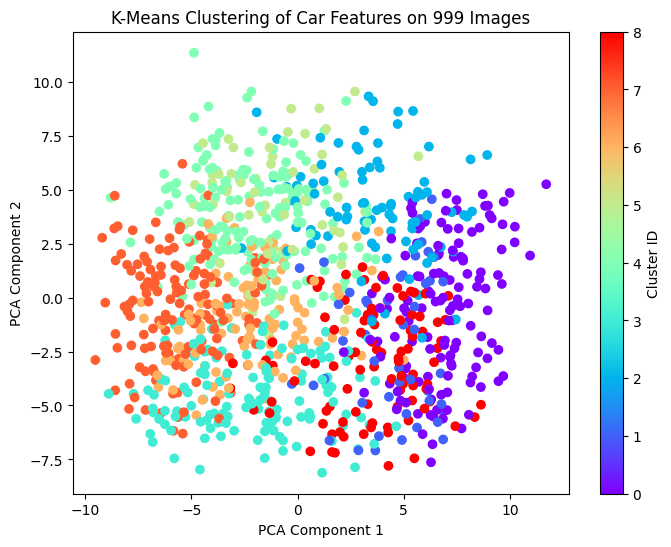

In [39]:
visualize_clustering(features_list, clustering, 2)

In [40]:
visualize_clustering(features_list, clustering, 3)

### **Bước 3**: Hiển thị kết quả Clustering (Updated)

In [36]:
def display_images(df=None,
                   csv_file='Clustering_results.csv',
                   base_dir='./',
                   dataset_dir='./',
                   num_imgs_per_row=10,
                   img_height=150,
                   img_width=150,):
    # Đọc file CSV
    csv_path = os.path.join(dataset_dir, csv_file)
    if df is None:
        df = pd.read_csv(csv_path)

    # Lấy danh sách các ClusterID
    clusters = df['ClusterID'].unique()

    # Thiết lập vùng visualize/Điều chỉnh figsize cho phù hợp với số lượng ảnh
    fig_height = len(clusters) * (img_height / 100)
    fig_width = num_imgs_per_row * (img_width / 100)
    plt.figure(figsize=(fig_height, fig_width))

    for i, cluster in enumerate(tqdm(clusters, desc="Processing clusters", unit=" cluster")):
        # Lấy ảnh thuộc cluster hiện tại
        cluster_imgs = df[df['ClusterID'] == cluster]['ImageFullPath'].tolist()
        # Chọn ngẫu nhiên ảnh
        selected_imgs = random.sample(cluster_imgs, min(len(cluster_imgs), num_imgs_per_row))

        # Tạo subplot cho ClusterID (đặt nó ở cột đầu tiên mỗi hàng)
        ax = plt.subplot(len(clusters), num_imgs_per_row + 1, i * (num_imgs_per_row + 1) + 1)
        ax.text(0.5, 0.5, "Cluster " + str(cluster),
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax.axis("off")

        # Hiển thị các ảnh trong hàng
        for j, img_path in enumerate(selected_imgs):
            ax = plt.subplot(len(clusters), num_imgs_per_row + 1, i * (num_imgs_per_row + 1) + j + 2)
            try:
                img = Image.open(os.path.join(base_dir, img_path))
                img = img.resize((img_width, img_height))
                ax.imshow(img)
                ax.axis("off")
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                ax.axis("off")

    # Điều chỉnh layout
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.tight_layout()
    plt.show()


Processing clusters: 100%|██████████| 9/9 [00:04<00:00,  2.08 cluster/s]


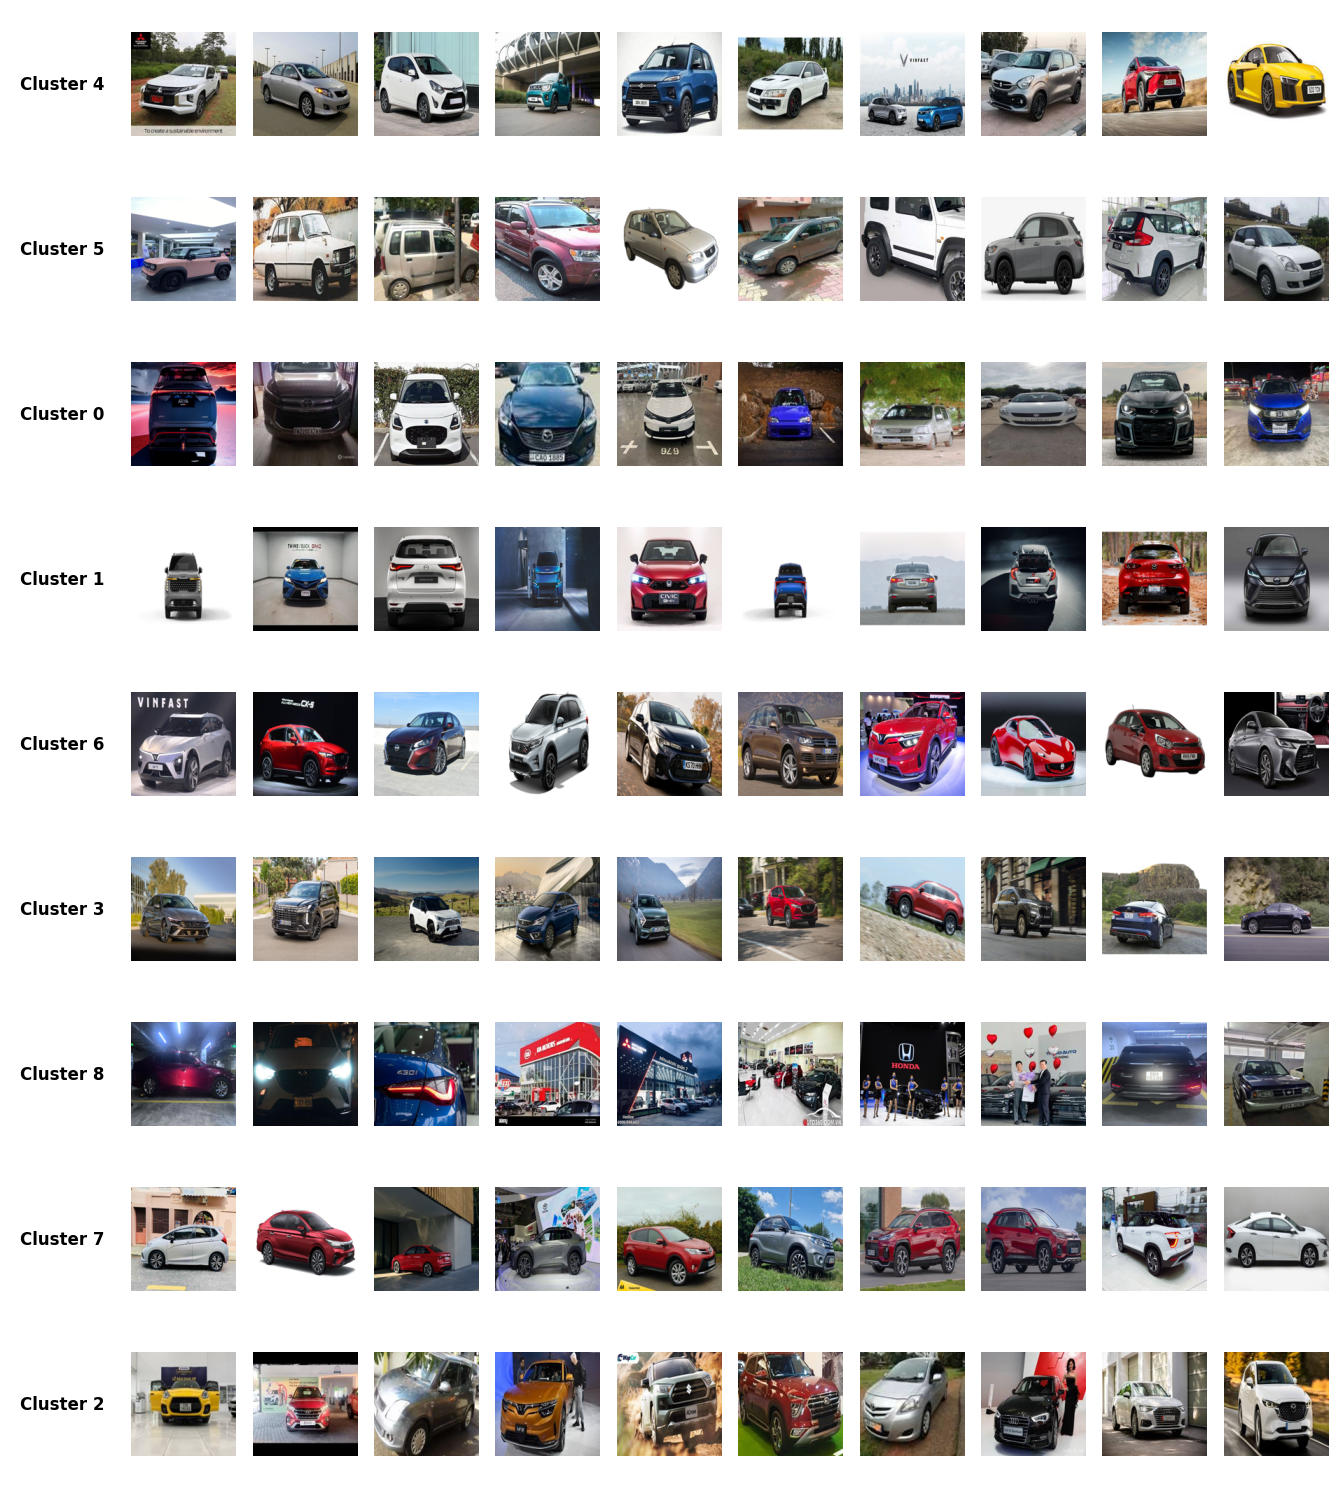

In [37]:
display_images(csv_file='Clustering_results.csv', base_dir=base_dir, dataset_dir=dataset_dir, num_imgs_per_row=10, img_height=150, img_width=150)

#### Calculating similarity to find duplicate images
- [x] Euclidean
- [ ] Cosine Similarity (W.I.P)

In [65]:
def find_duplicate(extracted_features=None,
                   dataset_dir='./',
                   extracted_file='extracted_features-Splits-1.npz',
                   similarity_threshold=0.9,
                   metric='cosine',
                   save_result=False,
                   save_name='duplicate_images.csv'):

    if extracted_features is None:
        file_path = os.path.join(dataset_dir, extracted_file)
        data = np.load(file_path, allow_pickle=True)
        extracted_features = data['extracted_features']

    features_list = [x['Extracted Features'] for x in extracted_features]
    image_path_list = [x['ImagePath'] for x in extracted_features]

    duplicate_images = []
    num_images = len(features_list)

    for i in range(num_images):
        for j in range(i + 1, num_images):
            if metric == 'cosine': # Still not working as intended (too slow, may require dimension reduction)
                similarity = cosine_similarity([features_list[i]], [features_list[j]])[0][0]
                if similarity > similarity_threshold:
                    print(f"Found duplicate images: {image_path_list[i]} and {image_path_list[j]} with cosine similarity {similarity}")
                    duplicate_images.append((image_path_list[i], image_path_list[j], similarity))
            elif metric == 'euclidean':
                distance = euclidean(features_list[i], features_list[j])
                if distance < 1.0 - similarity_threshold:
                    print(f"Found duplicate images: {image_path_list[i]} and {image_path_list[j]} with euclidean distance {distance}")
                    duplicate_images.append((image_path_list[i], image_path_list[j], distance))
            elif metric == 'ssim':  # Didn't test
                img1 = imread(image_path_list[i], as_gray=True)
                img2 = imread(image_path_list[j], as_gray=True)
                if img1.shape != img2.shape:
                    img2 = np.resize(img2, img1.shape)
                ssim_value = ssim(img1, img2)
                if ssim_value > similarity_threshold:
                    print(f"Found duplicate images: {image_path_list[i]} and {image_path_list[j]} with SSIM {ssim_value}")
                    duplicate_images.append((image_path_list[i], image_path_list[j], ssim_value))
    if save_result:
        save_path = os.path.join(dataset_dir, save_name)
        df = pd.DataFrame(duplicate_images, columns=["Image1", "Image2", "Score"])
        df.to_csv(save_path, index=False)
        print(f"Saved to {save_path}")

    return duplicate_images


In [66]:
duplicate_images = find_duplicate(extracted_features=extracted_features, dataset_dir=dataset_dir)

Found duplicate images: VinFast/22521027-22520195-22521060.VinFast.0723.jpg and VinFast/22520477-22520490.VinFast.42.jpg with similarity 1.0
Found duplicate images: Toyota/21520938-22520634.Toyota.192.jpg and Toyota/21520938-22520634.Toyota.306.jpg with similarity 0.9366299510002136
Found duplicate images: KIA/22521027-22520195-22521060.KIA.496.jpg and KIA/22521027-22520195-22521060.KIA.472.jpg with similarity 0.9480487704277039
Found duplicate images: KIA/22521027-22520195-22521060.KIA.728.jpg and KIA/22521027-22520195-22521060.KIA.707.jpg with similarity 0.9384111762046814
Found duplicate images: KIA/22521027-22520195-22521060.KIA.728.jpg and KIA/22521027-22520195-22521060.KIA.250.jpg with similarity 0.9003288149833679


In [80]:
# Temp plot function
def plot_image_pairs(image_pairs, base_dir):
    rows = len(image_pairs)
    fig, axes = plt.subplots(rows, 2, figsize=(10, rows * 5))

    if rows == 1:
        axes = [axes]

    for i, (image_path1, image_path2, scores) in enumerate(image_pairs):
        full_path1 = os.path.join(base_dir, image_path1)
        full_path2 = os.path.join(base_dir, image_path2)

        img1 = Image.open(full_path1)
        img2 = Image.open(full_path2)

        axes[i][0].imshow(img1)
        axes[i][0].axis('off')
        axes[i][0].set_title(image_path1.split('/')[-1])

        axes[i][1].imshow(img2)
        axes[i][1].axis('off')
        axes[i][1].set_title(image_path2.split('/')[-1])

        score_text = f'Similarity Score: {scores:.3f}'
        axes[i][0].text(1.1, 0.5, score_text, ha='center', va='center', transform=axes[i][0].transAxes, rotation=90)

    plt.tight_layout()
    plt.show()


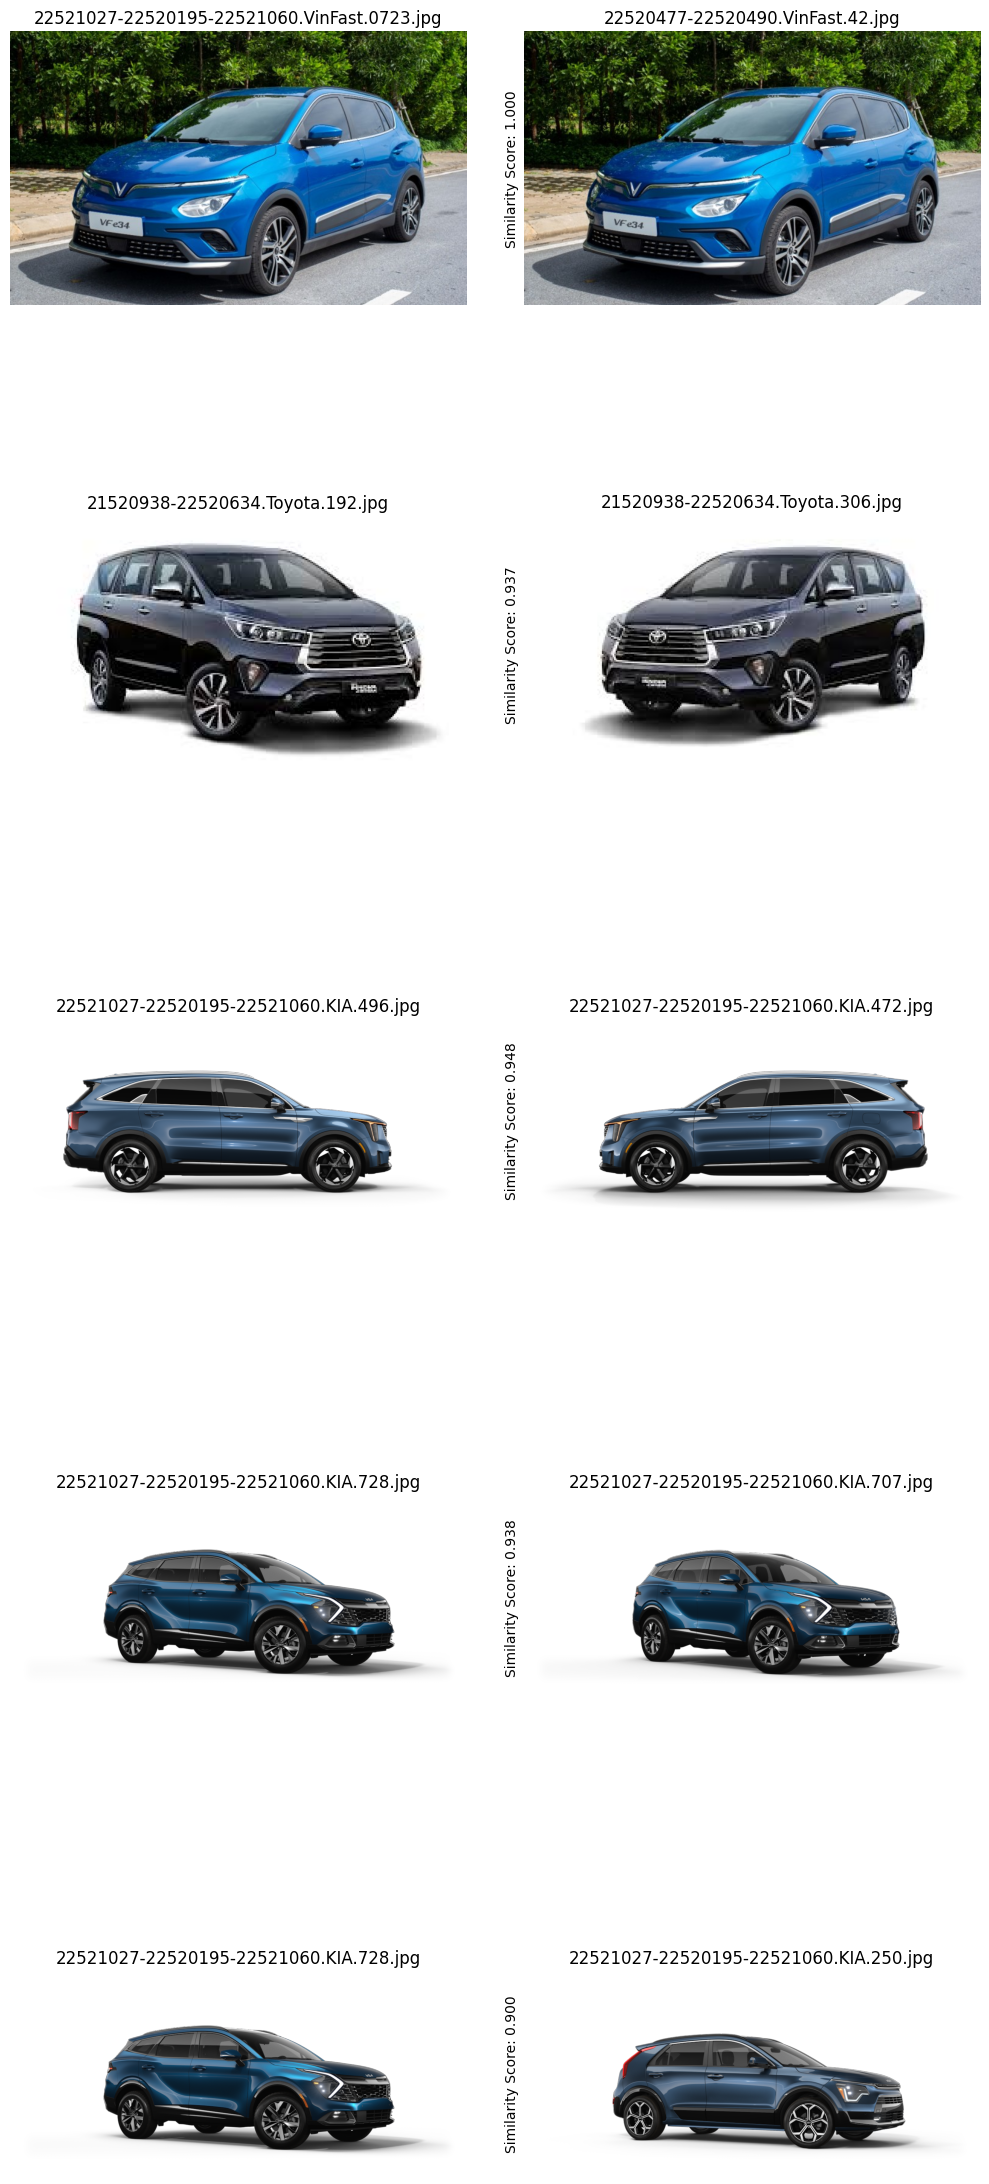

In [81]:
plot_image_pairs(duplicate_images, base_dir=base_dir)